<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/resnet34%20parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd '/content/drive/MyDrive/imageunderstanding'
!ls

[Errno 2] No such file or directory: '/content/drive/MyDrive/imageunderstanding'
/content/drive/MyDrive/551 A3
mlruns	Test.pkl  Train_labels.csv  Train.pkl


In [5]:
%cd '/content/drive/MyDrive/551 A3'
!ls

/content/drive/MyDrive/551 A3
mlruns	Test.pkl  Train_labels.csv  Train.pkl


In [6]:
TRAIN_DATA_PATH = "Train.pkl"
TRAIN_LABEL_PATH = "Train_labels.csv"
TEST_DATA_PATH = "Test.pkl"
CSV_OUTPUT_PATH = "PRED_RESULT.csv"

In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch
import pandas as pd

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [9]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Dataset Class / Data Loaders

In [10]:
IMG_SIZE = (224, 224)

In [11]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5]),
    transforms.Resize(IMG_SIZE)  
    # transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
    # transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, interpolation=<InterpolationMode.NEAREST: 'nearest'>, fill=0, fillcolor=None, resample=None)
])

In [12]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1, usecols=1) #[:,1:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index].squeeze(), int(self.targets[index])
        img = Image.fromarray((img*255).astype('uint8'), mode='L')
        if self.transform is not None:
           img = self.transform(img)
        return img, target

Get loader for all train data

In [13]:
BATCH_SIZE = 128
dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=None)
# dataloader for all data
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Get loaders for train/val data

In [14]:
VAL_SPLIT = 0.15
shuffle = True

# Creating indices for train and val split:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SPLIT * dataset_size))
if shuffle:
  # set random seed so that we get the same split everytime
  np.random.seed(0)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=train_indices)
val_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=val_indices)

# separate loaders for train and val data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Test Dataset / Loader

In [ ]:
class MyTestSet(Dataset):
  def __init__(self, img_file, transform=None):
    self.data = pickle.load( open(img_file, 'rb' ), encoding='bytes')
    self.transform = transform

  def __len__(self):
    # return self.data.shape[0]
    return len(self.data)

  def __getitem__(self, index):
    img = self.data[index].squeeze()
    img = Image.fromarray((img*255).astype('uint8'), mode='L')
    if self.transform is not None:
      img = self.transform(img)
    return img

In [ ]:
test_dataset = MyTestSet(TEST_DATA_PATH,transform=img_transform)
# dataloader for test data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## ResNet18

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision.models as models

In [17]:
import optuna
import mlflow
from pprint import pformat
from torch.optim.lr_scheduler import StepLR

In [ ]:
! pip install optuna
! pip install mlflow

Let's train these. But first, create the network, the optimizer and some lists for logging the training process

### alexnet

In [ ]:
# model = models.alexnet(pretrained=False)
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
# model.classifier[6] = nn.Linear(4096, 10)
# model = model.to(DEVICE)

### resnet18

In [ ]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(DEVICE)

### resnet34

In [18]:
model = models.resnet34(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(DEVICE)

### optimizer & initialization

In [ ]:
# optimizer = optim.SGD(tutor_model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.SGD(tutor_model.parameters(), lr=1, momentum=0.5)
# optimizer = optim.Adam(model.parameters())
optimizer = optim.RMSprop(model.parameters())

train_losses = []
train_counter = []
val_losses = []
val_counter = [i*len(train_loader.dataset) for i in range(3)]

### Train and test function, used many times

In [ ]:
def train(epoch, model, loader):
  model.train()
  for batch_idx, (data, target) in enumerate(loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    # print(data.shape)
    target = target.to(DEVICE)
    output = model(data)
    # print(output.shape)
    # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D
    loss = F.cross_entropy(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 200 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(loader.dataset),
        100. * batch_idx / len(loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(loader.dataset)))
      torch.save(model.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def val(model, loader):
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = model(data)
      val_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  val_loss /= len(loader.dataset)
  val_losses.append(val_loss)
  print('Val set: Epoch: {}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    epoch, val_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)))

In [19]:
# for hyperparameter
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_set_size = len(train_loader.dataset)
    num_batches = len(train_loader)
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            batch_size = len(data)
            print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_set_size} "
                  f"({100. * batch_idx / num_batches:.0f}%)]\tLoss: {loss.item():.6f}")
    avg_train_loss = train_loss / num_batches
    return avg_train_loss

# Testing loop
def val(model, device, val_loader):
    model.eval()
    val_set_size = len(val_loader.dataset)
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= val_set_size

    print(f"Test set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{val_set_size} "
          f"({100. * correct / val_set_size:.0f}%)\n")
    return val_loss

### parameter selection

In [20]:
def suggest_hyperparameters(trial):
    # Obtain the learning rate on a logarithmic scale
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # Obtain the dropout ratio in a range from 0.0 to 0.9 with step size 0.1
    #dropout = trial.suggest_float("dropout", 0.0, 0.9, step=0.1)
    # Obtain the optimizer to use by name
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop"])
    #momentum= trial.suggest_uniform('momentum', 0.4, 0.99)

    print(f"Suggested hyperparameters: \n{pformat(trial.params)}")
    return lr,  optimizer_name#,momentum#dropout

In [22]:
def objective(trial):
    print("\n********************************\n")
    best_val_loss = float('Inf')
    
    # Start a new mlflow run
    with mlflow.start_run():
        # Get hyperparameter suggestions created by optuna and log them as params using mlflow
        #lr,  optimizer_name, momentum= suggest_hyperparameters(trial)
        
        lr,optimizer_name= suggest_hyperparameters(trial)
        mlflow.log_params(trial.params)

        # Use CUDA if GPU is available and log device as param using mlflow
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)

        # define model
        #model = Tutor_model(dropout=dropout).to(device)
        model = models.resnet34(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
        model = model.to(DEVICE)

        # Pick an optimizer based on optuna's parameter suggestion
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        if optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        
        # Get DataLoaders for MNIST train and validation set
        #train_loader, val_loader = get_mnist_dataloaders()
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        # Network training & validation loop
        for epoch in range(0, 3):
            avg_train_loss = train(model, device, train_loader, optimizer, epoch)
            #avg_train_loss = train( epoch,model,train_loader)
            avg_val_loss = val(model, device, val_loader)
            
            if avg_val_loss <= best_val_loss:
                best_val_loss = avg_val_loss

            # Log average train and validation set loss metrics for the current epoch using mlflow
            mlflow.log_metric("avg_train_losses", avg_train_loss, step=epoch)
            mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch)
            
            scheduler.step()

    # Return the best validation loss achieved by the network.
    # This is needed as Optuna needs to know how the suggested hyperparameters are influencing the network loss.
    return best_val_loss

In [23]:
    # Create the optuna study which shares the experiment name
    study = optuna.create_study(study_name="pytorch-mlflow-optuna", direction="minimize")
    study.optimize(objective, n_trials=10)

    # Print optuna study statistics
    print("\n++++++++++++++++++++++++++++++++++\n")
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Trial number: ", trial.number)
    print("  Loss (trial value): ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-04-11 13:31:27,782] A new study created in memory with name: pytorch-mlflow-optuna



********************************

Suggested hyperparameters: 
{'lr': 0.08817856001649262, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: 0.122030
Train Epoch: 0 [1280/51000 (3%)]	Loss: -62779.628906
Train Epoch: 0 [2560/51000 (5%)]	Loss: -159793.546875
Train Epoch: 0 [3840/51000 (8%)]	Loss: -262516.281250
Train Epoch: 0 [5120/51000 (10%)]	Loss: -368825.062500
Train Epoch: 0 [6400/51000 (13%)]	Loss: -480095.687500
Train Epoch: 0 [7680/51000 (15%)]	Loss: -592076.875000
Train Epoch: 0 [8960/51000 (18%)]	Loss: -708753.312500
Train Epoch: 0 [10240/51000 (20%)]	Loss: -828144.187500
Train Epoch: 0 [11520/51000 (23%)]	Loss: -947871.875000
Train Epoch: 0 [12800/51000 (25%)]	Loss: -1070985.750000
Train Epoch: 0 [14080/51000 (28%)]	Loss: -1198666.625000
Train Epoch: 0 [15360/51000 (30%)]	Loss: -1326569.000000
Train Epoch: 0 [16640/51000 (33%)]	Loss: -1458390.625000
Train Epoch: 0 [17920/51000 (35%)]	Loss: -1594263.125000
Train Epoch: 0 [19200/51000 (38%)]	Loss: -1729271.250000


[I 2021-04-11 13:44:19,517] Trial 0 finished with value: -18543871.594666667 and parameters: {'lr': 0.08817856001649262, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -18543871.5947, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.0156505275586736, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: -0.060833
Train Epoch: 0 [1280/51000 (3%)]	Loss: -3065.569336
Train Epoch: 0 [2560/51000 (5%)]	Loss: -7464.914062
Train Epoch: 0 [3840/51000 (8%)]	Loss: -12207.400391
Train Epoch: 0 [5120/51000 (10%)]	Loss: -17093.021484
Train Epoch: 0 [6400/51000 (13%)]	Loss: -22292.822266
Train Epoch: 0 [7680/51000 (15%)]	Loss: -27546.605469
Train Epoch: 0 [8960/51000 (18%)]	Loss: -32748.855469
Train Epoch: 0 [10240/51000 (20%)]	Loss: -38352.761719
Train Epoch: 0 [11520/51000 (23%)]	Loss: -44026.023438
Train Epoch: 0 [12800/51000 (25%)]	Loss: -49848.953125
Train Epoch: 0 [14080/51000 (28%)]	Loss: -55750.113281
Train Epoch: 0 [15360/51000 (30%)]	Loss: -61660.968750
Train Epoch: 0 [16640/51000 (33%)]	Loss: -67776.492188
Train Epoch: 0 [17920/51000 (35%)]	Loss: -73666.703125
Train Epoch

[I 2021-04-11 13:57:26,737] Trial 1 finished with value: -691523.9457777778 and parameters: {'lr': 0.0156505275586736, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -691523.9458, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.024439143665961418, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: 0.331203
Train Epoch: 0 [1280/51000 (3%)]	Loss: -6866.627441
Train Epoch: 0 [2560/51000 (5%)]	Loss: -17603.740234
Train Epoch: 0 [3840/51000 (8%)]	Loss: -29340.919922
Train Epoch: 0 [5120/51000 (10%)]	Loss: -41211.105469
Train Epoch: 0 [6400/51000 (13%)]	Loss: -53905.250000
Train Epoch: 0 [7680/51000 (15%)]	Loss: -66373.671875
Train Epoch: 0 [8960/51000 (18%)]	Loss: -79518.062500
Train Epoch: 0 [10240/51000 (20%)]	Loss: -92879.046875
Train Epoch: 0 [11520/51000 (23%)]	Loss: -106659.250000
Train Epoch: 0 [12800/51000 (25%)]	Loss: -120557.164062
Train Epoch: 0 [14080/51000 (28%)]	Loss: -134534.359375
Train Epoch: 0 [15360/51000 (30%)]	Loss: -149019.343750
Train Epoch: 0 [16640/51000 (33%)]	Loss: -163858.562500
Train Epoch: 0 [17920/51000 (35%)]	Loss: -178968.671875
Train

[I 2021-04-11 14:10:28,475] Trial 2 finished with value: -2086827.0293333333 and parameters: {'lr': 0.024439143665961418, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -2086827.0293, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.0749376557703811, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: -0.112378
Train Epoch: 0 [1280/51000 (3%)]	Loss: -48304.753906
Train Epoch: 0 [2560/51000 (5%)]	Loss: -125286.648438
Train Epoch: 0 [3840/51000 (8%)]	Loss: -207281.828125
Train Epoch: 0 [5120/51000 (10%)]	Loss: -291084.281250
Train Epoch: 0 [6400/51000 (13%)]	Loss: -379282.375000
Train Epoch: 0 [7680/51000 (15%)]	Loss: -469909.031250
Train Epoch: 0 [8960/51000 (18%)]	Loss: -563099.750000
Train Epoch: 0 [10240/51000 (20%)]	Loss: -658444.187500
Train Epoch: 0 [11520/51000 (23%)]	Loss: -754228.625000
Train Epoch: 0 [12800/51000 (25%)]	Loss: -852473.187500
Train Epoch: 0 [14080/51000 (28%)]	Loss: -954344.125000
Train Epoch: 0 [15360/51000 (30%)]	Loss: -1056015.125000
Train Epoch: 0 [16640/51000 (33%)]	Loss: -1161194.375000
Train Epoch: 0 [17920/51000 (35%)]	Loss: -1269806.7

[I 2021-04-11 14:23:25,678] Trial 3 finished with value: -14767015.658666667 and parameters: {'lr': 0.0749376557703811, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -14767015.6587, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.0033666815211116953, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: -0.564487
Train Epoch: 0 [1280/51000 (3%)]	Loss: -274.694092
Train Epoch: 0 [2560/51000 (5%)]	Loss: -527.646423
Train Epoch: 0 [3840/51000 (8%)]	Loss: -766.922791
Train Epoch: 0 [5120/51000 (10%)]	Loss: -1001.256104
Train Epoch: 0 [6400/51000 (13%)]	Loss: -1243.610962
Train Epoch: 0 [7680/51000 (15%)]	Loss: -1493.077637
Train Epoch: 0 [8960/51000 (18%)]	Loss: -1761.631958
Train Epoch: 0 [10240/51000 (20%)]	Loss: -2037.677368
Train Epoch: 0 [11520/51000 (23%)]	Loss: -2330.078125
Train Epoch: 0 [12800/51000 (25%)]	Loss: -2610.481934
Train Epoch: 0 [14080/51000 (28%)]	Loss: -2903.333740
Train Epoch: 0 [15360/51000 (30%)]	Loss: -3193.849854
Train Epoch: 0 [16640/51000 (33%)]	Loss: -3492.498779
Train Epoch: 0 [17920/51000 (35%)]	Loss: -3794.252441
Train Epoch: 0 [19200/5

[I 2021-04-11 14:36:42,087] Trial 4 finished with value: -34111.496069444445 and parameters: {'lr': 0.0033666815211116953, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -34111.4961, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.010286966403666472, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: 0.144238
Train Epoch: 0 [1280/51000 (3%)]	Loss: -1439.015503
Train Epoch: 0 [2560/51000 (5%)]	Loss: -3404.804688
Train Epoch: 0 [3840/51000 (8%)]	Loss: -5509.618652
Train Epoch: 0 [5120/51000 (10%)]	Loss: -7669.859375
Train Epoch: 0 [6400/51000 (13%)]	Loss: -9955.694336
Train Epoch: 0 [7680/51000 (15%)]	Loss: -12199.837891
Train Epoch: 0 [8960/51000 (18%)]	Loss: -14620.188477
Train Epoch: 0 [10240/51000 (20%)]	Loss: -17034.564453
Train Epoch: 0 [11520/51000 (23%)]	Loss: -19379.691406
Train Epoch: 0 [12800/51000 (25%)]	Loss: -21907.705078
Train Epoch: 0 [14080/51000 (28%)]	Loss: -24449.542969
Train Epoch: 0 [15360/51000 (30%)]	Loss: -26947.050781
Train Epoch: 0 [16640/51000 (33%)]	Loss: -29641.689453
Train Epoch: 0 [17920/51000 (35%)]	Loss: -32318.839844
Train Epoch: 0 [

[I 2021-04-11 14:49:56,663] Trial 5 finished with value: -373080.7532222222 and parameters: {'lr': 0.010286966403666472, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -373080.7532, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 5.394480774175557e-05, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: 0.021257
Train Epoch: 0 [1280/51000 (3%)]	Loss: -4.459945
Train Epoch: 0 [2560/51000 (5%)]	Loss: -9.117965
Train Epoch: 0 [3840/51000 (8%)]	Loss: -12.003106
Train Epoch: 0 [5120/51000 (10%)]	Loss: -11.950079
Train Epoch: 0 [6400/51000 (13%)]	Loss: -15.548339
Train Epoch: 0 [7680/51000 (15%)]	Loss: -14.092024
Train Epoch: 0 [8960/51000 (18%)]	Loss: -15.990333
Train Epoch: 0 [10240/51000 (20%)]	Loss: -19.710320
Train Epoch: 0 [11520/51000 (23%)]	Loss: -18.748993
Train Epoch: 0 [12800/51000 (25%)]	Loss: -20.918518
Train Epoch: 0 [14080/51000 (28%)]	Loss: -21.702404
Train Epoch: 0 [15360/51000 (30%)]	Loss: -24.388739
Train Epoch: 0 [16640/51000 (33%)]	Loss: -24.199007
Train Epoch: 0 [17920/51000 (35%)]	Loss: -22.718264
Train Epoch: 0 [19200/51000 (38%)]	Loss: -24.191341
T

[I 2021-04-11 15:03:19,485] Trial 6 finished with value: -75.57068210177951 and parameters: {'lr': 5.394480774175557e-05, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -75.5707, Accuracy: 7407/9000 (82%)


********************************

Suggested hyperparameters: 
{'lr': 0.004505340504806584, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: 0.141111
Train Epoch: 0 [1280/51000 (3%)]	Loss: -405.043793
Train Epoch: 0 [2560/51000 (5%)]	Loss: -820.066223
Train Epoch: 0 [3840/51000 (8%)]	Loss: -1218.954346
Train Epoch: 0 [5120/51000 (10%)]	Loss: -1632.819458
Train Epoch: 0 [6400/51000 (13%)]	Loss: -2075.149658
Train Epoch: 0 [7680/51000 (15%)]	Loss: -2516.170410
Train Epoch: 0 [8960/51000 (18%)]	Loss: -3012.458252
Train Epoch: 0 [10240/51000 (20%)]	Loss: -3485.030029
Train Epoch: 0 [11520/51000 (23%)]	Loss: -3956.569336
Train Epoch: 0 [12800/51000 (25%)]	Loss: -4438.796875
Train Epoch: 0 [14080/51000 (28%)]	Loss: -4960.432129
Train Epoch: 0 [15360/51000 (30%)]	Loss: -5458.080566
Train Epoch: 0 [16640/51000 (33%)]	Loss: -5971.684082
Train Epoch: 0 [17920/51000 (35%)]	Loss: -6508.886230
Train Epoch: 0 [19200/51000 (

[I 2021-04-11 15:16:35,620] Trial 7 finished with value: -71268.02872222223 and parameters: {'lr': 0.004505340504806584, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -71268.0287, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.005328890120664682, 'optimizer_name': 'Adam'}
Train Epoch: 0 [0/51000 (0%)]	Loss: 0.098299
Train Epoch: 0 [1280/51000 (3%)]	Loss: -52.024860
Train Epoch: 0 [2560/51000 (5%)]	Loss: -123.809708
Train Epoch: 0 [3840/51000 (8%)]	Loss: -213.186188
Train Epoch: 0 [5120/51000 (10%)]	Loss: -323.540192
Train Epoch: 0 [6400/51000 (13%)]	Loss: -456.125824
Train Epoch: 0 [7680/51000 (15%)]	Loss: -609.758545
Train Epoch: 0 [8960/51000 (18%)]	Loss: -792.357666
Train Epoch: 0 [10240/51000 (20%)]	Loss: -1002.801147
Train Epoch: 0 [11520/51000 (23%)]	Loss: -1239.360474
Train Epoch: 0 [12800/51000 (25%)]	Loss: -1501.916260
Train Epoch: 0 [14080/51000 (28%)]	Loss: -1798.984497
Train Epoch: 0 [15360/51000 (30%)]	Loss: -2123.649170
Train Epoch: 0 [16640/51000 (33%)]	Loss: -2554.703369
Train Epoch: 0 [17920/51000 (35%)]	Loss: -3028.429199
Train Epoch: 0 [19200/51000 (38%)]	L

[I 2021-04-11 15:29:57,734] Trial 8 finished with value: -121445.93455555555 and parameters: {'lr': 0.005328890120664682, 'optimizer_name': 'Adam'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -121445.9346, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.006998663274948015, 'optimizer_name': 'Adam'}
Train Epoch: 0 [0/51000 (0%)]	Loss: -0.053636
Train Epoch: 0 [1280/51000 (3%)]	Loss: -71.966888
Train Epoch: 0 [2560/51000 (5%)]	Loss: -174.014099
Train Epoch: 0 [3840/51000 (8%)]	Loss: -306.824982
Train Epoch: 0 [5120/51000 (10%)]	Loss: -470.843903
Train Epoch: 0 [6400/51000 (13%)]	Loss: -681.983032
Train Epoch: 0 [7680/51000 (15%)]	Loss: -925.843018
Train Epoch: 0 [8960/51000 (18%)]	Loss: -1219.416016
Train Epoch: 0 [10240/51000 (20%)]	Loss: -1563.603760
Train Epoch: 0 [11520/51000 (23%)]	Loss: -1951.331055
Train Epoch: 0 [12800/51000 (25%)]	Loss: -2398.400146
Train Epoch: 0 [14080/51000 (28%)]	Loss: -3025.781982
Train Epoch: 0 [15360/51000 (30%)]	Loss: -3690.212158
Train Epoch: 0 [16640/51000 (33%)]	Loss: -4398.932129
Train Epoch: 0 [17920/51000 (35%)]	Loss: -5173.255859
Train Epoch: 0 [19200/51000 (38%)

[I 2021-04-11 15:43:19,574] Trial 9 finished with value: -209088.02105555555 and parameters: {'lr': 0.006998663274948015, 'optimizer_name': 'Adam'}. Best is trial 0 with value: -18543871.594666667.


Test set: Average loss: -209088.0211, Accuracy: 895/9000 (10%)


++++++++++++++++++++++++++++++++++

Study statistics: 
  Number of finished trials:  10
Best trial:
  Trial number:  0
  Loss (trial value):  -18543871.594666667
  Params: 
    lr: 0.08817856001649262
    optimizer_name: RMSprop


In [ ]:
    # Create the optuna study which shares the experiment name
    study = optuna.create_study(study_name="pytorch-mlflow-optuna", direction="minimize")
    study.optimize(objective, n_trials=5)

    # Print optuna study statistics
    print("\n++++++++++++++++++++++++++++++++++\n")
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Trial number: ", trial.number)
    print("  Loss (trial value): ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-04-10 02:01:39,833] A new study created in memory with name: pytorch-mlflow-optuna



********************************

Suggested hyperparameters: 
{'lr': 0.0036371172103828496, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: -0.236404
Train Epoch: 0 [1280/51000 (3%)]	Loss: -223.694443
Train Epoch: 0 [2560/51000 (5%)]	Loss: -439.426666
Train Epoch: 0 [3840/51000 (8%)]	Loss: -648.061401
Train Epoch: 0 [5120/51000 (10%)]	Loss: -850.893860
Train Epoch: 0 [6400/51000 (13%)]	Loss: -1073.871704
Train Epoch: 0 [7680/51000 (15%)]	Loss: -1305.845337
Train Epoch: 0 [8960/51000 (18%)]	Loss: -1544.559204
Train Epoch: 0 [10240/51000 (20%)]	Loss: -1784.295654
Train Epoch: 0 [11520/51000 (23%)]	Loss: -2019.162598
Train Epoch: 0 [12800/51000 (25%)]	Loss: -2258.934570
Train Epoch: 0 [14080/51000 (28%)]	Loss: -2464.309082
Train Epoch: 0 [15360/51000 (30%)]	Loss: -2755.195557
Train Epoch: 0 [16640/51000 (33%)]	Loss: -3015.674316
Train Epoch: 0 [17920/51000 (35%)]	Loss: -3282.557129
Train Epoch: 0 [19200/51000 (38%)]	Loss: -3545.443115
Train Epoch: 0 [20480/51000 (40%)]	L

[I 2021-04-10 02:15:51,764] Trial 0 finished with value: -50743.825666666664 and parameters: {'lr': 0.0036371172103828496, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: -50743.825666666664.


Test set: Average loss: -50743.8257, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.022381284365837674, 'optimizer_name': 'Adam'}
Train Epoch: 0 [0/51000 (0%)]	Loss: -0.084154
Train Epoch: 0 [1280/51000 (3%)]	Loss: -215.963669
Train Epoch: 0 [2560/51000 (5%)]	Loss: -634.797363
Train Epoch: 0 [3840/51000 (8%)]	Loss: -1294.661499
Train Epoch: 0 [5120/51000 (10%)]	Loss: -2291.163818
Train Epoch: 0 [6400/51000 (13%)]	Loss: -3741.662842
Train Epoch: 0 [7680/51000 (15%)]	Loss: -5594.219727
Train Epoch: 0 [8960/51000 (18%)]	Loss: -7929.376953
Train Epoch: 0 [10240/51000 (20%)]	Loss: -10733.704102
Train Epoch: 0 [11520/51000 (23%)]	Loss: -14033.695312
Train Epoch: 0 [12800/51000 (25%)]	Loss: -17789.322266
Train Epoch: 0 [14080/51000 (28%)]	Loss: -22077.333984
Train Epoch: 0 [15360/51000 (30%)]	Loss: -26829.294922
Train Epoch: 0 [16640/51000 (33%)]	Loss: -32034.367188
Train Epoch: 0 [17920/51000 (35%)]	Loss: -37894.160156
Train Epoch: 0 [19200/

[I 2021-04-10 02:29:42,342] Trial 1 finished with value: -2367085.104 and parameters: {'lr': 0.022381284365837674, 'optimizer_name': 'Adam'}. Best is trial 1 with value: -2367085.104.


Test set: Average loss: -2367085.1040, Accuracy: 895/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.001937336250352337, 'optimizer_name': 'Adam'}
Train Epoch: 0 [0/51000 (0%)]	Loss: 0.084478
Train Epoch: 0 [1280/51000 (3%)]	Loss: -12.527074
Train Epoch: 0 [2560/51000 (5%)]	Loss: -29.100332
Train Epoch: 0 [3840/51000 (8%)]	Loss: -48.154404
Train Epoch: 0 [5120/51000 (10%)]	Loss: -68.911339
Train Epoch: 0 [6400/51000 (13%)]	Loss: -92.642693
Train Epoch: 0 [7680/51000 (15%)]	Loss: -117.458221
Train Epoch: 0 [8960/51000 (18%)]	Loss: -144.820496
Train Epoch: 0 [10240/51000 (20%)]	Loss: -174.894196
Train Epoch: 0 [11520/51000 (23%)]	Loss: -207.203400
Train Epoch: 0 [12800/51000 (25%)]	Loss: -241.282028
Train Epoch: 0 [14080/51000 (28%)]	Loss: -278.831421
Train Epoch: 0 [15360/51000 (30%)]	Loss: -318.036469
Train Epoch: 0 [16640/51000 (33%)]	Loss: -360.982300
Train Epoch: 0 [17920/51000 (35%)]	Loss: -406.845367
Train Epoch: 0 [19200/51000 (38%)]	Loss: -453

[I 2021-04-10 02:43:55,646] Trial 2 finished with value: -18087.707361111112 and parameters: {'lr': 0.001937336250352337, 'optimizer_name': 'Adam'}. Best is trial 1 with value: -2367085.104.


Test set: Average loss: -18087.7074, Accuracy: 898/9000 (10%)


********************************

Suggested hyperparameters: 
{'lr': 0.00010643990215300088, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: -0.038683
Train Epoch: 0 [1280/51000 (3%)]	Loss: -3.832893
Train Epoch: 0 [2560/51000 (5%)]	Loss: -7.857562
Train Epoch: 0 [3840/51000 (8%)]	Loss: -9.771683
Train Epoch: 0 [5120/51000 (10%)]	Loss: -11.484155
Train Epoch: 0 [6400/51000 (13%)]	Loss: -13.741072
Train Epoch: 0 [7680/51000 (15%)]	Loss: -14.211802
Train Epoch: 0 [8960/51000 (18%)]	Loss: -16.770096
Train Epoch: 0 [10240/51000 (20%)]	Loss: -18.993002
Train Epoch: 0 [11520/51000 (23%)]	Loss: -19.435329
Train Epoch: 0 [12800/51000 (25%)]	Loss: -21.023743
Train Epoch: 0 [14080/51000 (28%)]	Loss: -22.513855
Train Epoch: 0 [15360/51000 (30%)]	Loss: -24.788149
Train Epoch: 0 [16640/51000 (33%)]	Loss: -25.546314
Train Epoch: 0 [17920/51000 (35%)]	Loss: -25.184944
Train Epoch: 0 [19200/51000 (38%)]	Loss: -27.128344
T

[I 2021-04-10 02:58:08,476] Trial 3 finished with value: -135.37448882378473 and parameters: {'lr': 0.00010643990215300088, 'optimizer_name': 'RMSprop'}. Best is trial 1 with value: -2367085.104.


Test set: Average loss: -135.3745, Accuracy: 8666/9000 (96%)


********************************

Suggested hyperparameters: 
{'lr': 0.01861304613287783, 'optimizer_name': 'RMSprop'}
Train Epoch: 0 [0/51000 (0%)]	Loss: 0.045683
Train Epoch: 0 [1280/51000 (3%)]	Loss: -3129.826172
Train Epoch: 0 [2560/51000 (5%)]	Loss: -7757.903809
Train Epoch: 0 [3840/51000 (8%)]	Loss: -12927.195312
Train Epoch: 0 [5120/51000 (10%)]	Loss: -18150.269531
Train Epoch: 0 [6400/51000 (13%)]	Loss: -23631.914062
Train Epoch: 0 [7680/51000 (15%)]	Loss: -29186.041016
Train Epoch: 0 [8960/51000 (18%)]	Loss: -34908.343750
Train Epoch: 0 [10240/51000 (20%)]	Loss: -40810.878906
Train Epoch: 0 [11520/51000 (23%)]	Loss: -46664.046875
Train Epoch: 0 [12800/51000 (25%)]	Loss: -52746.484375
Train Epoch: 0 [14080/51000 (28%)]	Loss: -58874.832031
Train Epoch: 0 [15360/51000 (30%)]	Loss: -65243.402344
Train Epoch: 0 [16640/51000 (33%)]	Loss: -71337.476562
Train Epoch: 0 [17920/51000 (35%)]	Loss: -78309.515625
Train Epoch: 0 

[I 2021-04-10 03:12:01,755] Trial 4 finished with value: -1285948.324888889 and parameters: {'lr': 0.01861304613287783, 'optimizer_name': 'RMSprop'}. Best is trial 1 with value: -2367085.104.


Test set: Average loss: -1285948.3249, Accuracy: 895/9000 (10%)


++++++++++++++++++++++++++++++++++

Study statistics: 
  Number of finished trials:  5
Best trial:
  Trial number:  1
  Loss (trial value):  -2367085.104
  Params: 
    lr: 0.022381284365837674
    optimizer_name: Adam


Train the network

In [ ]:
for epoch in range(1, 20):
  train(epoch, model, train_loader)
  val(model, val_loader)

Train Epoch: 1 [0/51000 (0%)]	Loss: 2.501408
Train Epoch: 1 [25600/51000 (50%)]	Loss: 1.768204


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: Epoch: 1, Avg. loss: 0.6560, Accuracy: 7334/9000 (81%)
Train Epoch: 2 [0/51000 (0%)]	Loss: 0.399630
Train Epoch: 2 [25600/51000 (50%)]	Loss: 0.314973
Val set: Epoch: 2, Avg. loss: 0.3970, Accuracy: 8065/9000 (90%)
Train Epoch: 3 [0/51000 (0%)]	Loss: 0.172807
Train Epoch: 3 [25600/51000 (50%)]	Loss: 0.172641
Val set: Epoch: 3, Avg. loss: 0.2522, Accuracy: 8395/9000 (93%)
Train Epoch: 4 [0/51000 (0%)]	Loss: 0.098940
Train Epoch: 4 [25600/51000 (50%)]	Loss: 0.138717
Val set: Epoch: 4, Avg. loss: 0.2303, Accuracy: 8490/9000 (94%)
Train Epoch: 5 [0/51000 (0%)]	Loss: 0.153854
Train Epoch: 5 [25600/51000 (50%)]	Loss: 0.062233
Val set: Epoch: 5, Avg. loss: 0.1667, Accuracy: 8587/9000 (95%)
Train Epoch: 6 [0/51000 (0%)]	Loss: 0.059971
Train Epoch: 6 [25600/51000 (50%)]	Loss: 0.069005
Val set: Epoch: 6, Avg. loss: 0.1588, Accuracy: 8584/9000 (95%)
Train Epoch: 7 [0/51000 (0%)]	Loss: 0.048258
Train Epoch: 7 [25600/51000 (50%)]	Loss: 0.029516
Val set: Epoch: 7, Avg. loss: 0.1121, Accuracy

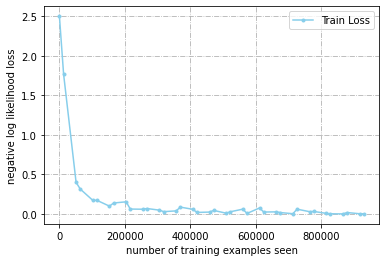

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='skyblue',marker='.')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.grid(linestyle='-.')

## Train on ALL data

In [ ]:
full_model = models.resnet34(pretrained=False)
full_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
full_model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
full_model = full_model.to(DEVICE)
optimizer = optim.RMSprop(full_model.parameters())

In [ ]:
for epoch in range(1, 19):
  train(epoch, full_model, data_loader)
  val(full_model, val_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.553793
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.109975
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.452095


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: Epoch: 1, Avg. loss: 0.4209, Accuracy: 7849/9000 (87%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.426845
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.116302
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.279465
Val set: Epoch: 2, Avg. loss: 0.3359, Accuracy: 8053/9000 (89%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.157237
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.170074
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.067195
Val set: Epoch: 3, Avg. loss: 0.3650, Accuracy: 8101/9000 (90%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.119769
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.098883
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.077822
Val set: Epoch: 4, Avg. loss: 0.1145, Accuracy: 8666/9000 (96%)
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.094105
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.186172
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.077245
Val set: Epoch: 5, Avg. loss: 0.1311, Accuracy: 8638/9000 (96%)
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.107980
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.120999
Train

## Make predictions on test data

In [ ]:
def predict(model):
  pred_test = []
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      data = data.to(DEVICE)
      output = model(data)
      pred = output.data.max(1, keepdim=True)[1]
      for x in pred:
        pred_test.append(x.item())
  return pred_test

In [ ]:
pred_test = predict(full_model)
print(len(pred_test))
df_pred_test = pd.DataFrame({'id': range(10000), 'class': pred_test})
df_pred_test.to_csv(CSV_OUTPUT_PATH, index=False)

10000


## Manually check prediction results

torch.Size([128, 1, 224, 224])
torch.Size([128, 224, 224])


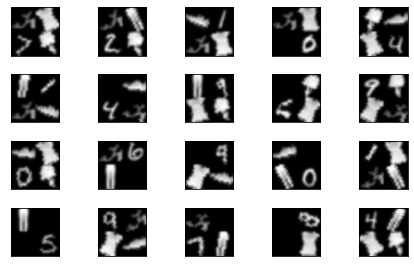

In [ ]:
# Read many TEST data and display them, compare with our prediction in CSV
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
imgs = (next(iter(test_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)

for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(imgs[i], cmap='gray', interpolation='bicubic')
  plt.xticks([])
  plt.yticks([])

## Deeper（doesn't work）

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    
    self.model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3), nn.ReLU(), # 26*26
      nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(), # 24*24
      # nn.MaxPool2d(2,2), # 13*13

      nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),  # 22*22
      nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),  # 20*20
      # nn.MaxPool2d(2,2),  # 6*6

      nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),  # 18*18
      nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),  # 16*16
      # nn.MaxPool2d(2,2),  # 2*2

      nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(), # 14*14
      nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),  # 12*12
      # nn.MaxPool2d(2,2),

      nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),  # 10*10
      nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),  # 8*8
      nn.MaxPool2d(2,2),  # 4*4

    )
    
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(0.25),
      # nn.Linear(4096, 256),
      nn.Linear(4096, 256),
      nn.ReLU(),

      nn.Dropout(0.5),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )
    
  def forward(self, x):
    f = self.model(x)
    y_pred = self.classifier(f)
    return y_pred

network = MyModel()
# summary(model, (3,256,256))

In [ ]:
optimizer = optim.Adam(network.parameters())

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)

    loss = F.nll_loss(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader:
      output = network(data)
      # this line is added to convert labels to LongTensor
      # target = target.type(torch.LongTensor)
      # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D

      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader.dataset),
    100. * correct / len(val_loader.dataset)))

In [ ]:
for epoch in range(1, 4):
  train(epoch)
  test()

In [ ]:
print(torch.cuda.is_available())

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Linear(3136, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # input 1*28*28
        self.conv1 = nn.Conv2d(1, 96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.max_pool2d(torch.relu(self.conv1(x)), kernel_size=3, stride=2) # 96 filters + maxpooling => 96*27*27
        x = F.max_pool2d(torch.relu(self.conv2(x)), kernel_size=3, stride=2) # 256 filters + maxpooling => 256*13*13
        x = torch.relu(self.conv3(x)) # 384 filters => 384*13*13
        x = torch.relu(self.conv4(x)) # 384 filters => 384*13*13
        x = F.max_pool2d(torch.relu(self.conv5(x)), kernel_size=3, stride=2) # 256 filters => 256*6*6
        x = self.dropout(x) 
        x = x.view(-1, 256*6*6) 
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x)